Problem 1

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB
None

Unique origin values: [1 3 2]

First few rows of the dataset:
    mpg  cylinders  displacement  horsepower  weight  acceleration  model_year  origin  \
0 18.00          8        307.00      130.00 3504.00         12.00          70       1   
1 15.00          8        350.00      165.00 3693.00         11.50          70       1   
2

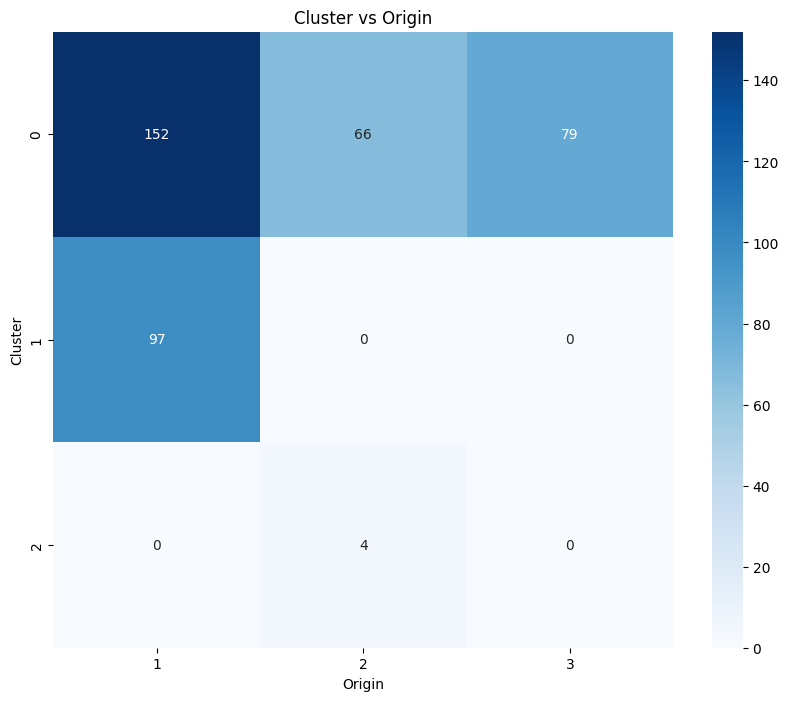

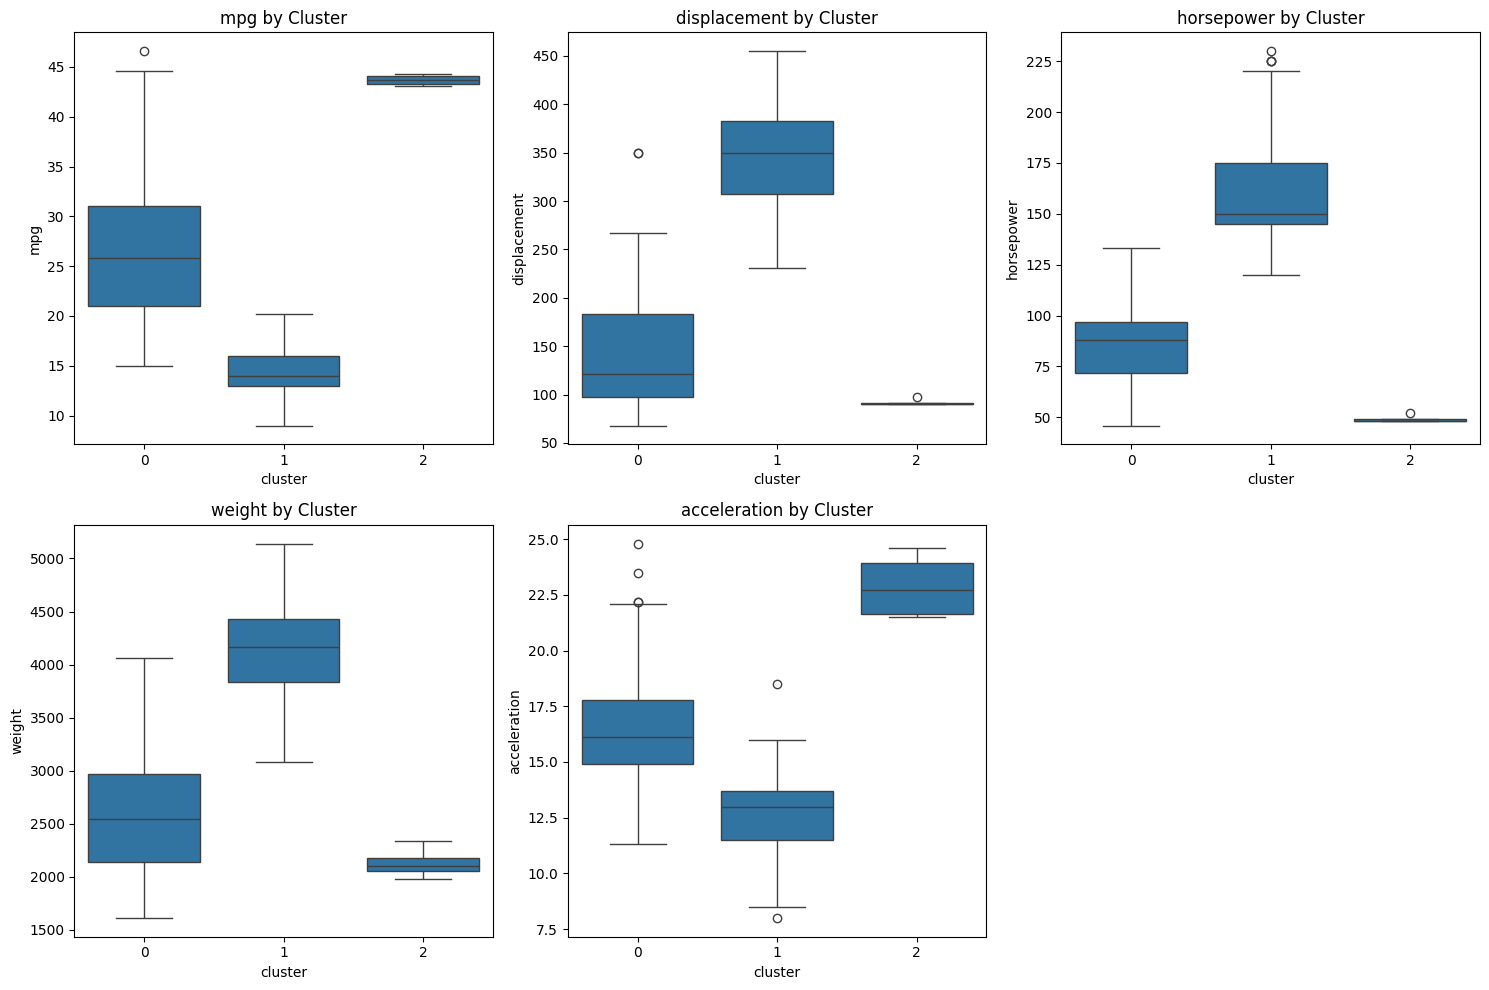

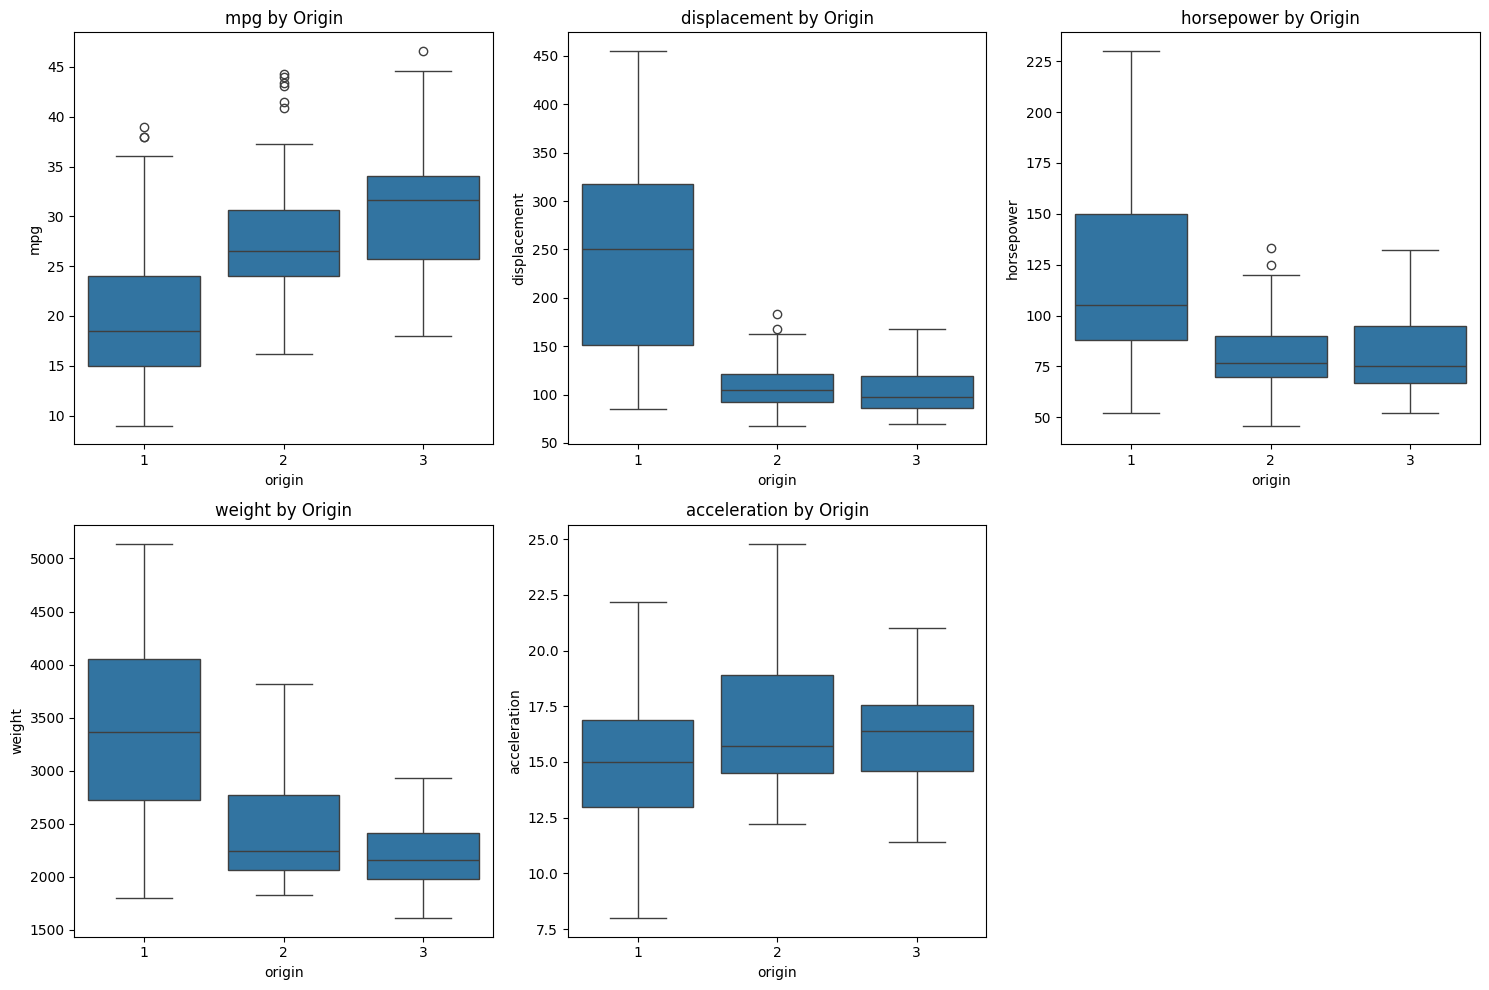


Analysis of relationship between cluster assignment and class label:
Cluster 0 contains 51.18% of cars from origin 1
Cluster 1 contains 100.00% of cars from origin 1
Cluster 2 contains 100.00% of cars from origin 2

Overall clustering purity: 0.6357

Adjusted Rand Index (ARI): -0.0507
Normalized Mutual Information (NMI): 0.1988

Conclusion:
The relationship between cluster assignment and origin (class label) is not very strong.


In [28]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 设置 Pandas 显示选项
pd.set_option('display.precision', 2)  # 浮点数保留 2 位小数
pd.set_option('display.float_format', '{:.2f}'.format)  # 格式化浮点数
pd.set_option('display.max_columns', 20)  # 确保所有列显示
pd.set_option('display.width', 100)  # 设置输出宽度，避免换行


# 加载auto-mpg数据集
# 定义列名，因为原始数据不包含列名
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
# 从UCI库加载数据集，并将数据集中的 ? 标记为缺失值,较新的版本
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
df = pd.read_csv(url, sep=r'\s+', names=column_names, na_values='?')

# 查看数据集的基本信息
print("Dataset Information:")
print(df.info())
print("\nUnique origin values:", df['origin'].unique())
print("\nFirst few rows of the dataset:")
print(df.head())

# 数据预处理
# 只保留连续特征
continuous_features = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
X = df[continuous_features]

# 检查缺失值
print("\nMissing values in each column:")
print(X.isnull().sum())

# 使用均值填充缺失值
X = X.fillna(X.mean())

# 查看填充后的数据
print("\nAfter imputation, missing values in each column:")
print(X.isnull().sum())

# 执行层次聚类
# 标准化数据,防止大尺度数据主导距离计算，确保计算公平
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 执行层次聚类，设置linkage为average，metric为euclidean，得到3个聚类
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='average', metric='euclidean')
clusters = hierarchical.fit_predict(X_scaled)

# 将聚类标签添加到原始数据框
df['cluster'] = clusters

# 计算每个聚类的均值和方差
cluster_stats = df.groupby('cluster')[continuous_features].agg(['mean', 'var'])
print("\nCluster Statistics (Mean and Variance for each cluster):")
print(cluster_stats)

# 使用origin作为类标签计算统计量
class_stats = df.groupby('origin')[continuous_features].agg(['mean', 'var'])
print("\nClass Statistics (using 'origin' as class label):")
print(class_stats)

# 分析聚类分配与类标签之间的关系
# 创建混淆矩阵
conf_matrix = pd.crosstab(df['cluster'], df['origin'], rownames=['Cluster'], colnames=['Origin'])
print("\nConfusion Matrix (Cluster vs Origin):")
print(conf_matrix)

# 计算每个聚类中不同origin的百分比
percentage_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0) * 100
print("\nPercentage of each origin in clusters:")
print(percentage_matrix)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Cluster vs Origin')
plt.xlabel('Origin')
plt.ylabel('Cluster')
plt.savefig('confusion_matrix.png')
plt.show()

# 根据聚类结果绘制箱线图
plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.savefig('cluster_boxplots.png')
plt.show()

# 根据origin绘制箱线图
plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='origin', y=feature, data=df)
    plt.title(f'{feature} by Origin')
plt.tight_layout()
plt.savefig('origin_boxplots.png')
plt.show()

# 分析聚类与类标签之间的关系
print("\nAnalysis of relationship between cluster assignment and class label:")
for cluster in range(3):
    dominant_origin = percentage_matrix.loc[cluster].idxmax()
    dominant_percentage = percentage_matrix.loc[cluster, dominant_origin]
    print(f"Cluster {cluster} contains {dominant_percentage:.2f}% of cars from origin {dominant_origin}")

# 计算聚类纯度（每个聚类中最主要origin的百分比）
purity = 0
total_samples = len(df)
for cluster in range(3):
    max_count = conf_matrix.loc[cluster].max()
    cluster_size = conf_matrix.loc[cluster].sum()
    purity += max_count
purity = purity / total_samples
print(f"\nOverall clustering purity: {purity:.4f}")
# 计算 ARI 和 NMI

# ARI
ari = adjusted_rand_score(df['origin'], clusters)
print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")

# NMI
nmi = normalized_mutual_info_score(df['origin'], clusters)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# 判断聚类与origin之间是否存在明确关系
print("\nConclusion:")
if purity > 0.7 and ari>0.5 and nmi>0.5:
    print("There is a clear relationship between cluster assignment and origin (class label).")
else:
    print("The relationship between cluster assignment and origin (class label) is not very strong.")

Problem 2

Boston Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB
None

First few rows:
   CRIM    ZN  INDUS  CHAS  NOX   RM   AGE  DIS  RAD    TAX  PTRATIO      B  LSTAT  MEDV
0  0.01 18.00   2.31  0.00 0.54 6.58 65.20 4.09 1.00 296.00    15.30 396.90   4.98 24.00
1  0.03  0.00   7.07  0.

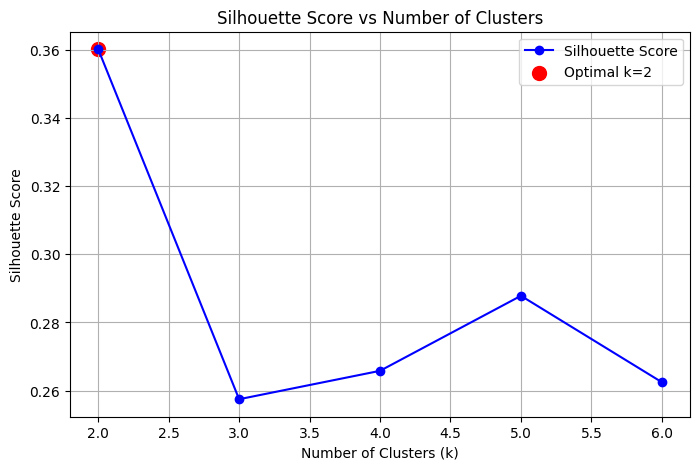


Mean values for all features in each cluster:
         CRIM    ZN  INDUS  CHAS  NOX   RM   AGE  DIS   RAD    TAX  PTRATIO      B  LSTAT
Cluster                                                                                  
0        0.26 17.48   6.89  0.07 0.49 6.46 56.34 4.76  4.47 301.92    17.84 386.45   9.47
1        9.84  0.00  19.04  0.07 0.68 5.97 91.32 2.01 18.99 605.86    19.60 301.33  18.57

Centroid coordinates (transformed back to original scale):
   CRIM    ZN  INDUS  CHAS  NOX   RM   AGE  DIS   RAD    TAX  PTRATIO      B  LSTAT
0  0.26 17.48   6.89  0.07 0.49 6.46 56.34 4.76  4.47 301.92    17.84 386.45   9.47
1  9.84  0.00  19.04  0.07 0.68 5.97 91.32 2.01 18.99 605.86    19.60 301.33  18.57

Difference between cluster means and centroid coordinates:
         CRIM    ZN  INDUS  CHAS   NOX   RM   AGE  DIS   RAD   TAX  PTRATIO    B  LSTAT
Cluster                                                                                
0        0.00 -0.00  -0.00  0.00 -0.00 0.00 -

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 加载 Boston 数据集,较新的版本
from sklearn.datasets import fetch_openml
boston = fetch_openml(name="boston", version=1, as_frame=True)
df = boston.frame

# 将所有 category 类型转换为数值类型，确保可以计算均值
for col in df.columns:
    if df[col].dtype.name == 'category':
        df[col] = df[col].astype(float)

# 查看数据集基本信息
print("Boston Dataset Information:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\n")
# 数据预处理：移除目标变量 MEDV，仅使用特征进行聚类
X = df.drop('MEDV', axis=1)
feature_names = X.columns

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 执行 K-Means 聚类，k 值从 2 到 6
silhouette_scores = []
k_range = range(2, 7)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.4f}")

# 确定最优 k 值
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nThe optimal number of clusters is {optimal_k} with silhouette score of {max(silhouette_scores):.4f}")

# 可视化轮廓分数
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, 'o-', color='blue', label='Silhouette Score')
plt.scatter(optimal_k, max(silhouette_scores), color='red', s=100, label=f'Optimal k={optimal_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.legend()
plt.savefig('silhouette_scores.png')
plt.show()

# 使用最优 k 值进行 K-Means 聚类
optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
optimal_labels = optimal_kmeans.fit_predict(X_scaled)

# 将聚类标签添加到原始数据框
df['Cluster'] = optimal_labels

# 计算每个聚类的特征均值
cluster_means = df.groupby('Cluster')[feature_names].mean()
print("\nMean values for all features in each cluster:")
print(cluster_means.round(2))

# 获取质心坐标并转换回原始特征尺度
centroids_scaled = optimal_kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_original, columns=feature_names)
print("\nCentroid coordinates (transformed back to original scale):")
print(centroids_df.round(2))

# 比较均值与质心坐标（仅比较特征列，不包括MEDV）
print("\nDifference between cluster means and centroid coordinates:")
difference = cluster_means - centroids_df
print(difference.round(4))
print("\nNote: These differences should be close to zero since K-Means centroids are defined as the mean of samples in each cluster. Any small differences may be due to numerical precision or scaling transformations.")

Problem 3

In [17]:
# 导入所需的库
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
import matplotlib.pyplot as plt

# 加载葡萄酒数据集
wine = load_wine()
X = wine.data
y = wine.target

# 将数据转换为Pandas DataFrame
wine_df = pd.DataFrame(X, columns=wine.feature_names)

# 查看数据集基本信息
print("Wine Dataset Information:")
print(wine_df.info())
print("\nFirst few rows:")
print(wine_df.head())
print("\n")
print(f"Number of samples: {wine_df.shape[0]}")
print(f"Number of features: {wine_df.shape[1]}")
print(f"Actual classes: {np.unique(y)}")

# 数据标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
scaled_df = pd.DataFrame(X_scaled, columns=wine.feature_names)

# 应用K-means聚类算法，设置聚类数为3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 计算同质性和完整性指标
homogeneity = homogeneity_score(y, clusters)
completeness = completeness_score(y, clusters)
v_measure = v_measure_score(y, clusters)

# 输出评估结果
print("\nClustering Evaluation Metrics:")
print(f"Homogeneity score: {homogeneity:.4f}")
print(f"Completeness score: {completeness:.4f}")
print(f"V-measure score: {v_measure:.4f}")

# 创建交叉表以比较真实标签和聚类标签
cross_tab = pd.crosstab(y, clusters, rownames=['True Class'], colnames=['Cluster'])
print("\nCross-tabulation of True Classes vs. Clusters:")
print(cross_tab)

# 同质性、完整性和 V-Measure 指标的解释
print("\nExplanation of Metrics:")
print("Homogeneity (range [0, 1]): Measures whether each cluster contains only members of a single class; a higher score indicates purer clusters.")
print("Completeness (range [0, 1]): Measures whether all members of a given class are assigned to the same cluster; a higher score indicates better class cohesion.")
print("V-Measure (range [0, 1]): The harmonic mean of Homogeneity and Completeness, providing a balanced measure of clustering quality; a higher score indicates better alignment with true labels.")
print("Low scores suggest that the clustering does not align well with the true class labels, possibly due to overlapping feature distributions.")

Wine Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-

In [ ]:
Evaluate the optimal k value

Wine Dataset Information:
Number of samples: 178
Number of features: 13
Target classes: [0 1 2]


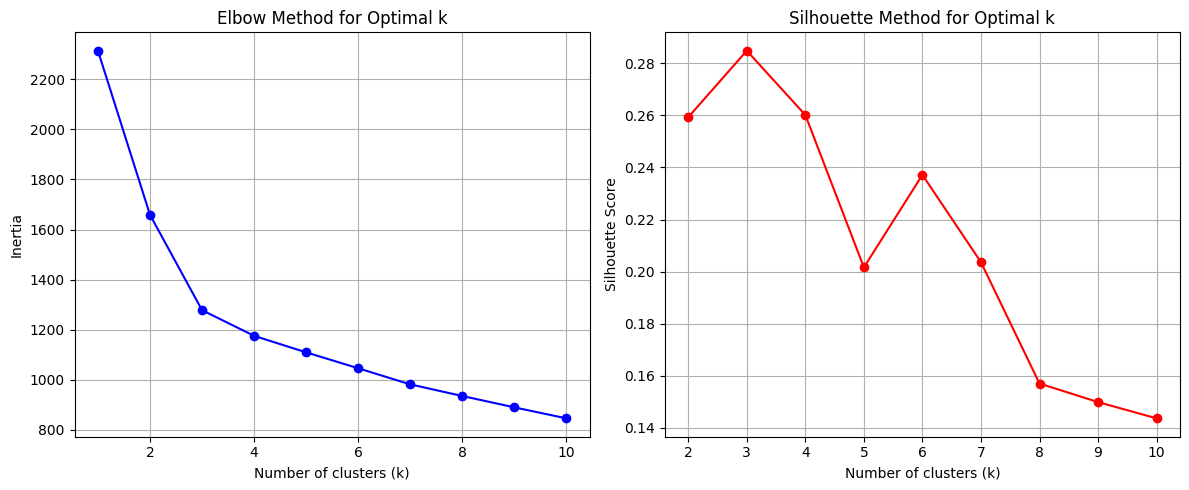


Best number of clusters (k) based on evaluation: 3


In [4]:
# 导入所需的库
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score
import matplotlib.pyplot as plt

# 加载葡萄酒数据集
wine = load_wine()
X = wine.data
y = wine.target

# 将数据转换为Pandas DataFrame
wine_df = pd.DataFrame(X, columns=wine.feature_names)

# 查看数据集基本信息
print("Wine Dataset Information:")
print(f"Number of samples: {wine_df.shape[0]}")
print(f"Number of features: {wine_df.shape[1]}")
print(f"Actual classes: {np.unique(y)}")

# 数据标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
scaled_df = pd.DataFrame(X_scaled, columns=wine.feature_names)

# 使用肘部法则确定最佳k值
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 使用轮廓系数评估不同的k值
silhouette_scores = []
for k in range(2, 11):  # 轮廓系数需要至少2个簇
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, clusters))

# 可视化肘部法则和轮廓系数以确定最佳k值
plt.figure(figsize=(12, 5))

# 肘部法则图
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# 轮廓系数图
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()

# 根据评估结果确定最佳k值
best_k = 3  
print(f"\nBest number of clusters (k) based on evaluation: {best_k}")


Visualizing clustering results (Use only the first two features)

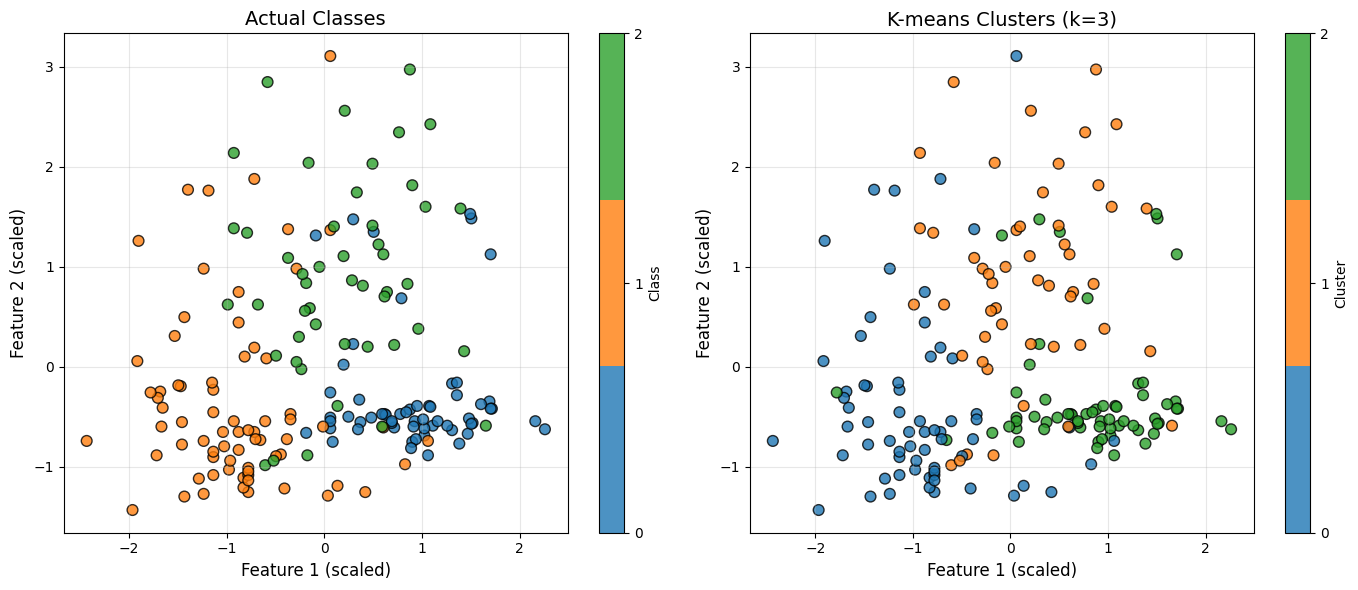


Clustering Evaluation Metrics:
Homogeneity score: 0.8788
Completeness score: 0.8730


In [9]:
# 导入所需的库
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 加载葡萄酒数据集
wine = load_wine()
X = wine.data
y = wine.target

# 数据标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 应用K-means聚类算法，设置聚类数为3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 计算同质性和完整性指标
homogeneity = homogeneity_score(y, clusters)
completeness = completeness_score(y, clusters)

# 创建一个自定义的颜色映射 - 使用鲜明的颜色
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 蓝色、橙色和绿色
custom_cmap = ListedColormap(colors)

# 可视化聚类结果（使用前两个特征）
plt.figure(figsize=(14, 6))

# 绘制真实类别
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=custom_cmap, 
                     edgecolor='k', s=60, alpha=0.8)
plt.title('Actual Classes', fontsize=14)
plt.xlabel('Feature 1 (scaled)', fontsize=12)
plt.ylabel('Feature 2 (scaled)', fontsize=12)
plt.grid(alpha=0.3)
plt.colorbar(scatter, ticks=[0, 1, 2], label='Class')

# 绘制聚类结果 - 使用相同的颜色映射
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=custom_cmap, 
                     edgecolor='k', s=60, alpha=0.8)
plt.title('K-means Clusters (k=3)', fontsize=14)
plt.xlabel('Feature 1 (scaled)', fontsize=12)
plt.ylabel('Feature 2 (scaled)', fontsize=12)
plt.grid(alpha=0.3)
plt.colorbar(scatter, ticks=[0, 1, 2], label='Cluster')

plt.tight_layout()
plt.show()

# 输出评估结果
print("\nClustering Evaluation Metrics:")
print(f"Homogeneity score: {homogeneity:.4f}")
print(f"Completeness score: {completeness:.4f}")

Visualizing clustering results (Use PCA for dimensionality reduction)

Wine Dataset Information:
Number of samples: 178
Number of features: 13
Target classes: [0 1 2]

Clustering Evaluation Metrics:
Homogeneity score: 0.8788
Completeness score: 0.8730

PCA Explained Variance:
First component: 0.3620 (36.20%)
Second component: 0.1921 (19.21%)
Total variance explained by first 2 components: 0.5541 (55.41%)

Components needed for 90% variance: 8


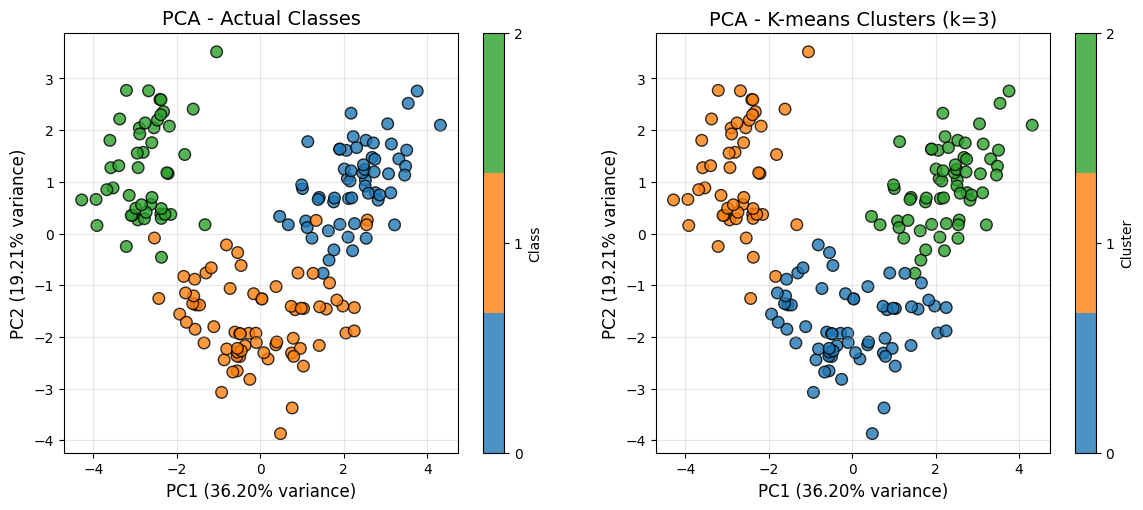

In [16]:
# 导入所需的库
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, completeness_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 加载葡萄酒数据集
wine = load_wine()
X = wine.data
y = wine.target

# 将数据转换为Pandas DataFrame
wine_df = pd.DataFrame(X, columns=wine.feature_names)

# 查看数据集基本信息
print("Wine Dataset Information:")
print(f"Number of samples: {wine_df.shape[0]}")
print(f"Number of features: {wine_df.shape[1]}")
print(f"Actual classes: {np.unique(y)}")

# 数据标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用PCA降维到2维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 获取PCA的解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 应用K-means聚类算法，设置聚类数为3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)  # 在原始高维空间中聚类

# 计算同质性和完整性指标
homogeneity = homogeneity_score(y, clusters)
completeness = completeness_score(y, clusters)

# 创建自定义颜色映射
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 蓝色、橙色和绿色
custom_cmap = ListedColormap(colors)

# 创建2行2列的图表
plt.figure(figsize=(14, 12))

# 1. PCA降维 - 显示真实类别
plt.subplot(2, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=custom_cmap, 
                     edgecolor='k', s=70, alpha=0.8)
plt.title('PCA - Actual Classes', fontsize=14)
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} variance)', fontsize=12)
plt.grid(alpha=0.3)
plt.colorbar(scatter, ticks=[0, 1, 2], label='Class')

# 2. PCA降维 - 显示聚类结果
plt.subplot(2, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap=custom_cmap, 
                     edgecolor='k', s=70, alpha=0.8)
plt.title('PCA - K-means Clusters (k=3)', fontsize=14)
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} variance)', fontsize=12)
plt.grid(alpha=0.3)
plt.colorbar(scatter, ticks=[0, 1, 2], label='Cluster')

# 输出评估结果与解释方差
print("\nClustering Evaluation Metrics:")
print(f"Homogeneity score: {homogeneity:.4f}")
print(f"Completeness score: {completeness:.4f}")

print("\nPCA Explained Variance:")
print(f"First component: {explained_variance_ratio[0]:.4f} ({explained_variance_ratio[0]:.2%})")
print(f"Second component: {explained_variance_ratio[1]:.4f} ({explained_variance_ratio[1]:.2%})")
print(f"Total variance explained by first 2 components: {sum(explained_variance_ratio):.4f} ({sum(explained_variance_ratio):.2%})")

# 计算需要多少个主成分才能解释90%的方差
cumsum = np.cumsum(full_pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum >= 0.9) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")